In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import seaborn as sns

In [2]:
dfi = pd.read_csv('./Data/Electricity/RE_elecDemand.csv')
dfi

Unnamed: 0               Time  Season  Day_of_the_week  DHI  DNI  GHI  \
0                0  2019-01-01-T00:00       1                1  0.0  0.0  0.0   
1                1  2019-01-01-T00:05       1                1  0.0  0.0  0.0   
2                2  2019-01-01-T00:10       1                1  0.0  0.0  0.0   
3                3  2019-01-01-T00:15       1                1  0.0  0.0  0.0   
4                4  2019-01-01-T00:20       1                1  0.0  0.0  0.0   
...            ...                ...     ...              ...  ...  ...  ...   
315643      315643  2021-12-31-T23:35       4                4  0.0  0.0  0.0   
315644      315644  2021-12-31-T23:40       4                4  0.0  0.0  0.0   
315645      315645  2021-12-31-T23:45       4                4  0.0  0.0  0.0   
315646      315646  2021-12-31-T23:50       4                4  0.0  0.0  0.0   
315647      315647  2021-12-31-T23:55       4                4  0.0  0.0  0.0   

        Wind_speed  Humidity  Temperature  PV_production  Wind_production  \
0             2.88    56.036         1.82              0             2810   
1             2.88    56.036         1.82              0             2862   
2             2.88    56.194         1.78              0             2916   
3             2.88    56.344         1.74              0             2920   
4             2.84    56.440         1.72              0             2902   
...            ...       ...          ...            ...              ...   
315643        1.64    64.898         5.68            -33             3778   
315644        1.64    64.970         5.66            -32             3755   
315645        1.64    65.042         5.64            -31             3751   
315646        1.64    65.234         5.60            -32             3793   
315647        1.62    65.308         5.58            -32             3801   

        Electric_demand  
0                 22216  
1                 22106  
2                 22130  
3                 22040  
4                 21963  
...                 ...  
315643            22939  
315644            22855  
315645            22812  
315646            22723  
315647            22662  

[315648 rows x 13 columns]

In [3]:
dfi['Time'] = pd.to_datetime(dfi['Time'])
dfi

Unnamed: 0                Time  Season  Day_of_the_week  DHI  DNI  \
0                0 2019-01-01 00:00:00       1                1  0.0  0.0   
1                1 2019-01-01 00:05:00       1                1  0.0  0.0   
2                2 2019-01-01 00:10:00       1                1  0.0  0.0   
3                3 2019-01-01 00:15:00       1                1  0.0  0.0   
4                4 2019-01-01 00:20:00       1                1  0.0  0.0   
...            ...                 ...     ...              ...  ...  ...   
315643      315643 2021-12-31 23:35:00       4                4  0.0  0.0   
315644      315644 2021-12-31 23:40:00       4                4  0.0  0.0   
315645      315645 2021-12-31 23:45:00       4                4  0.0  0.0   
315646      315646 2021-12-31 23:50:00       4                4  0.0  0.0   
315647      315647 2021-12-31 23:55:00       4                4  0.0  0.0   

        GHI  Wind_speed  Humidity  Temperature  PV_production  \
0       0.0        2.88    56.036         1.82              0   
1       0.0        2.88    56.036         1.82              0   
2       0.0        2.88    56.194         1.78              0   
3       0.0        2.88    56.344         1.74              0   
4       0.0        2.84    56.440         1.72              0   
...     ...         ...       ...          ...            ...   
315643  0.0        1.64    64.898         5.68            -33   
315644  0.0        1.64    64.970         5.66            -32   
315645  0.0        1.64    65.042         5.64            -31   
315646  0.0        1.64    65.234         5.60            -32   
315647  0.0        1.62    65.308         5.58            -32   

        Wind_production  Electric_demand  
0                  2810            22216  
1                  2862            22106  
2                  2916            22130  
3                  2920            22040  
4                  2902            21963  
...                 ...              ...  
315643             3778            22939  
315644             3755            22855  
315645             3751            22812  
315646             3793            22723  
315647             3801            22662  

[315648 rows x 13 columns]

In [4]:
dfi = dfi.groupby([pd.Grouper(freq='H', key='Time')]).mean().reset_index()
dfi

Time  Unnamed: 0  Season  Day_of_the_week  DHI  DNI  GHI  \
0     2019-01-01 00:00:00         5.5     1.0              1.0  0.0  0.0  0.0   
1     2019-01-01 01:00:00        17.5     1.0              1.0  0.0  0.0  0.0   
2     2019-01-01 02:00:00        29.5     1.0              1.0  0.0  0.0  0.0   
3     2019-01-01 03:00:00        41.5     1.0              1.0  0.0  0.0  0.0   
4     2019-01-01 04:00:00        53.5     1.0              1.0  0.0  0.0  0.0   
...                   ...         ...     ...              ...  ...  ...  ...   
26299 2021-12-31 19:00:00    315593.5     4.0              4.0  0.0  0.0  0.0   
26300 2021-12-31 20:00:00    315605.5     4.0              4.0  0.0  0.0  0.0   
26301 2021-12-31 21:00:00    315617.5     4.0              4.0  0.0  0.0  0.0   
26302 2021-12-31 22:00:00    315629.5     4.0              4.0  0.0  0.0  0.0   
26303 2021-12-31 23:00:00    315641.5     4.0              4.0  0.0  0.0  0.0   

       Wind_speed   Humidity  Temperature  PV_production  Wind_production  \
0        2.838333  55.809333     1.683333       0.000000      2812.083333   
1        2.770000  55.159000     1.405000       0.000000      2499.500000   
2        2.690000  54.532833     1.186667       0.000000      2387.083333   
3        2.655000  54.317833     0.985000       0.000000      2369.333333   
4        2.628333  54.296667     0.811667       0.000000      2323.083333   
...           ...        ...          ...            ...              ...   
26299    1.718333  64.786667     7.090000     -31.083333      3440.416667   
26300    1.658333  65.098167     6.751667     -32.166667      3448.916667   
26301    1.661667  65.315667     6.405000     -31.666667      3673.500000   
26302    1.675000  65.576167     6.045000     -31.083333      3826.000000   
26303    1.646667  65.622167     5.715000     -31.583333      3787.583333   

       Electric_demand  
0         21851.416667  
1         21099.666667  
2         20495.416667  
3         20147.500000  
4         20144.416667  
...                ...  
26299     26447.333333  
26300     25743.083333  
26301     25009.250000  
26302     24060.250000  
26303     23071.916667  

[26304 rows x 13 columns]

<Axes: >

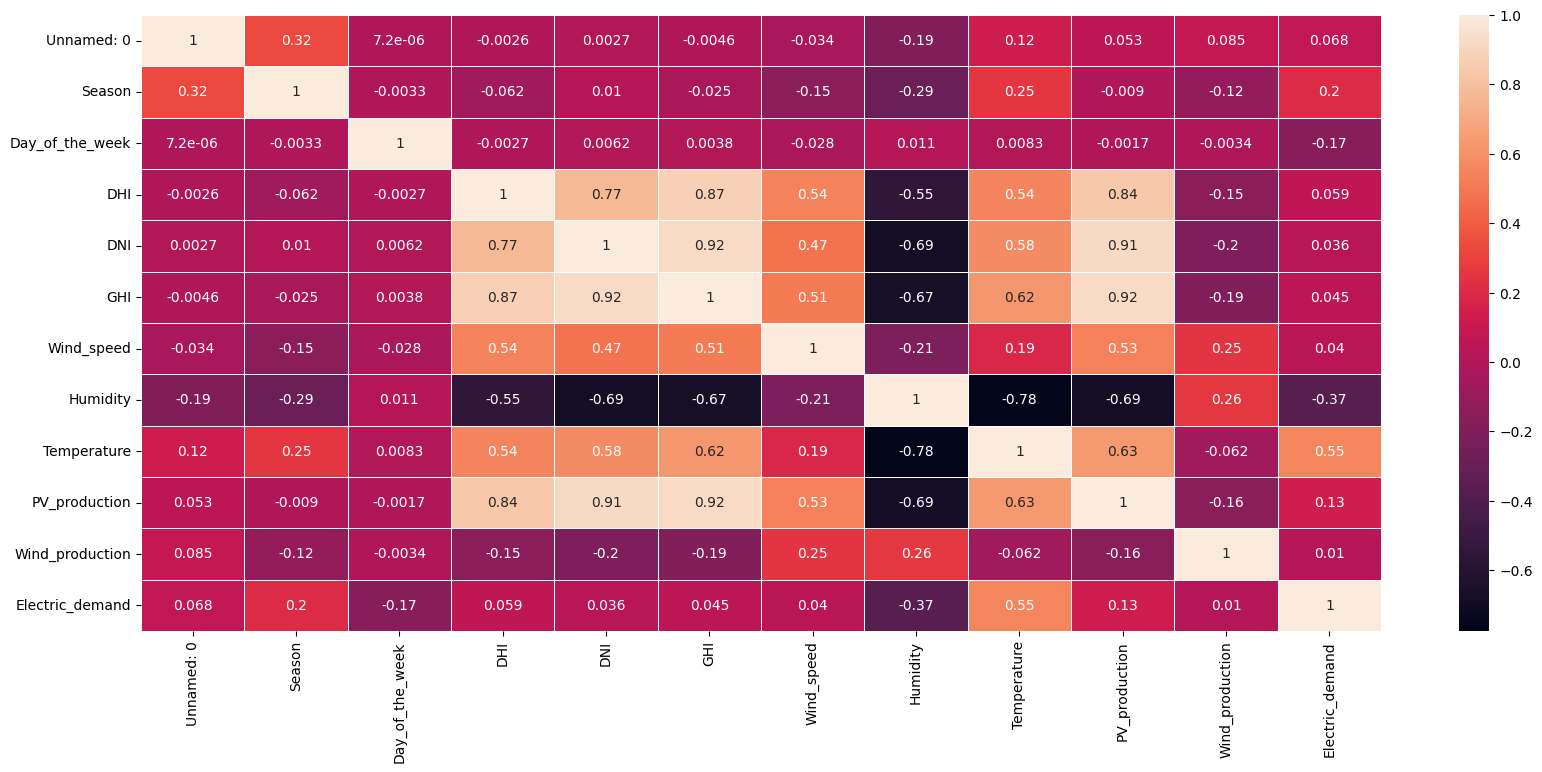

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8))
corr = dfi.select_dtypes('number').corr()
sns.heatmap(data=corr, annot=True, linewidths=.5,ax=ax)

In [7]:
df = dfi.loc[dfi['Time'] > '2021-07-01']
df.reset_index(inplace=True)
df.drop(['index','Unnamed: 0','Season','Day_of_the_week','DHI','DNI','GHI','Wind_production'],axis=1,inplace=True)
df.set_index('Time',inplace=True)
df

/tmp/ipykernel_63353/4087111129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index','Unnamed: 0','Season','Day_of_the_week','DHI','DNI','GHI','Wind_production'],axis=1,inplace=True)


Wind_speed   Humidity  Temperature  PV_production  \
Time                                                                     
2021-07-01 01:00:00    2.173333  61.006167    20.168333     -26.833333   
2021-07-01 02:00:00    2.163333  62.209167    19.781667     -27.333333   
2021-07-01 03:00:00    2.113333  63.125500    19.521667     -26.583333   
2021-07-01 04:00:00    2.105000  62.260500    19.936667     -28.666667   
2021-07-01 05:00:00    2.246667  57.512833    21.611667     -19.333333   
...                         ...        ...          ...            ...   
2021-12-31 19:00:00    1.718333  64.786667     7.090000     -31.083333   
2021-12-31 20:00:00    1.658333  65.098167     6.751667     -32.166667   
2021-12-31 21:00:00    1.661667  65.315667     6.405000     -31.666667   
2021-12-31 22:00:00    1.675000  65.576167     6.045000     -31.083333   
2021-12-31 23:00:00    1.646667  65.622167     5.715000     -31.583333   

                     Electric_demand  
Time                                  
2021-07-01 01:00:00     25633.916667  
2021-07-01 02:00:00     24665.083333  
2021-07-01 03:00:00     24081.250000  
2021-07-01 04:00:00     24046.666667  
2021-07-01 05:00:00     24650.666667  
...                              ...  
2021-12-31 19:00:00     26447.333333  
2021-12-31 20:00:00     25743.083333  
2021-12-31 21:00:00     25009.250000  
2021-12-31 22:00:00     24060.250000  
2021-12-31 23:00:00     23071.916667  

[4415 rows x 5 columns]

In [8]:
df.ffill()

Wind_speed   Humidity  Temperature  PV_production  \
Time                                                                     
2021-07-01 01:00:00    2.173333  61.006167    20.168333     -26.833333   
2021-07-01 02:00:00    2.163333  62.209167    19.781667     -27.333333   
2021-07-01 03:00:00    2.113333  63.125500    19.521667     -26.583333   
2021-07-01 04:00:00    2.105000  62.260500    19.936667     -28.666667   
2021-07-01 05:00:00    2.246667  57.512833    21.611667     -19.333333   
...                         ...        ...          ...            ...   
2021-12-31 19:00:00    1.718333  64.786667     7.090000     -31.083333   
2021-12-31 20:00:00    1.658333  65.098167     6.751667     -32.166667   
2021-12-31 21:00:00    1.661667  65.315667     6.405000     -31.666667   
2021-12-31 22:00:00    1.675000  65.576167     6.045000     -31.083333   
2021-12-31 23:00:00    1.646667  65.622167     5.715000     -31.583333   

                     Electric_demand  
Time                                  
2021-07-01 01:00:00     25633.916667  
2021-07-01 02:00:00     24665.083333  
2021-07-01 03:00:00     24081.250000  
2021-07-01 04:00:00     24046.666667  
2021-07-01 05:00:00     24650.666667  
...                              ...  
2021-12-31 19:00:00     26447.333333  
2021-12-31 20:00:00     25743.083333  
2021-12-31 21:00:00     25009.250000  
2021-12-31 22:00:00     24060.250000  
2021-12-31 23:00:00     23071.916667  

[4415 rows x 5 columns]

In [9]:
# Descriptive statistics
df.describe().T

count          mean          std           min  \
Wind_speed       4415.0      2.469447     0.979284      0.691667   
Humidity         4415.0     48.914517    15.732358     17.199833   
Temperature      4415.0     19.802525     7.807649      2.263333   
PV_production    4415.0   3746.645998  4647.386451    -81.333333   
Electric_demand  4415.0  26414.435598  5222.736921  17294.000000   

                          25%           50%           75%           max  
Wind_speed           1.718333      2.293333      3.069167      8.465000  
Humidity            36.460250     49.000333     60.112750     85.087667  
Temperature         13.685833     20.010000     25.037500     37.316667  
PV_production      -39.916667    118.333333   8648.791667  12750.916667  
Electric_demand  22616.583333  25237.916667  28765.583333  43762.416667

In [10]:
df['nxt_target'] = df['Electric_demand'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
df

/tmp/ipykernel_63353/2374012871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nxt_target'] = df['Electric_demand'].shift(-1)
/tmp/ipykernel_63353/2374012871.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_63353/2374012871.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target

Wind_speed   Humidity  Temperature  PV_production  \
Time                                                                     
2021-07-01 01:00:00    2.173333  61.006167    20.168333     -26.833333   
2021-07-01 02:00:00    2.163333  62.209167    19.781667     -27.333333   
2021-07-01 03:00:00    2.113333  63.125500    19.521667     -26.583333   
2021-07-01 04:00:00    2.105000  62.260500    19.936667     -28.666667   
2021-07-01 05:00:00    2.246667  57.512833    21.611667     -19.333333   
...                         ...        ...          ...            ...   
2021-12-31 19:00:00    1.718333  64.786667     7.090000     -31.083333   
2021-12-31 20:00:00    1.658333  65.098167     6.751667     -32.166667   
2021-12-31 21:00:00    1.661667  65.315667     6.405000     -31.666667   
2021-12-31 22:00:00    1.675000  65.576167     6.045000     -31.083333   
2021-12-31 23:00:00    1.646667  65.622167     5.715000     -31.583333   

                     Electric_demand    nxt_target  
Time                                                
2021-07-01 01:00:00     25633.916667  24665.083333  
2021-07-01 02:00:00     24665.083333  24081.250000  
2021-07-01 03:00:00     24081.250000  24046.666667  
2021-07-01 04:00:00     24046.666667  24650.666667  
2021-07-01 05:00:00     24650.666667  25514.916667  
...                              ...           ...  
2021-12-31 19:00:00     26447.333333  25743.083333  
2021-12-31 20:00:00     25743.083333  25009.250000  
2021-12-31 21:00:00     25009.250000  24060.250000  
2021-12-31 22:00:00     24060.250000  23071.916667  
2021-12-31 23:00:00     23071.916667  23071.916667  

[4415 rows x 6 columns]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4415 entries, 2021-07-01 01:00:00 to 2021-12-31 23:00:00
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Wind_speed       4415 non-null   float64
 1   Humidity         4415 non-null   float64
 2   Temperature      4415 non-null   float64
 3   PV_production    4415 non-null   float64
 4   Electric_demand  4415 non-null   float64
 5   nxt_target       4415 non-null   float64
dtypes: float64(6)
memory usage: 241.4 KB


# **STATISTICAL TESTS**

<Axes: xlabel='Time'>

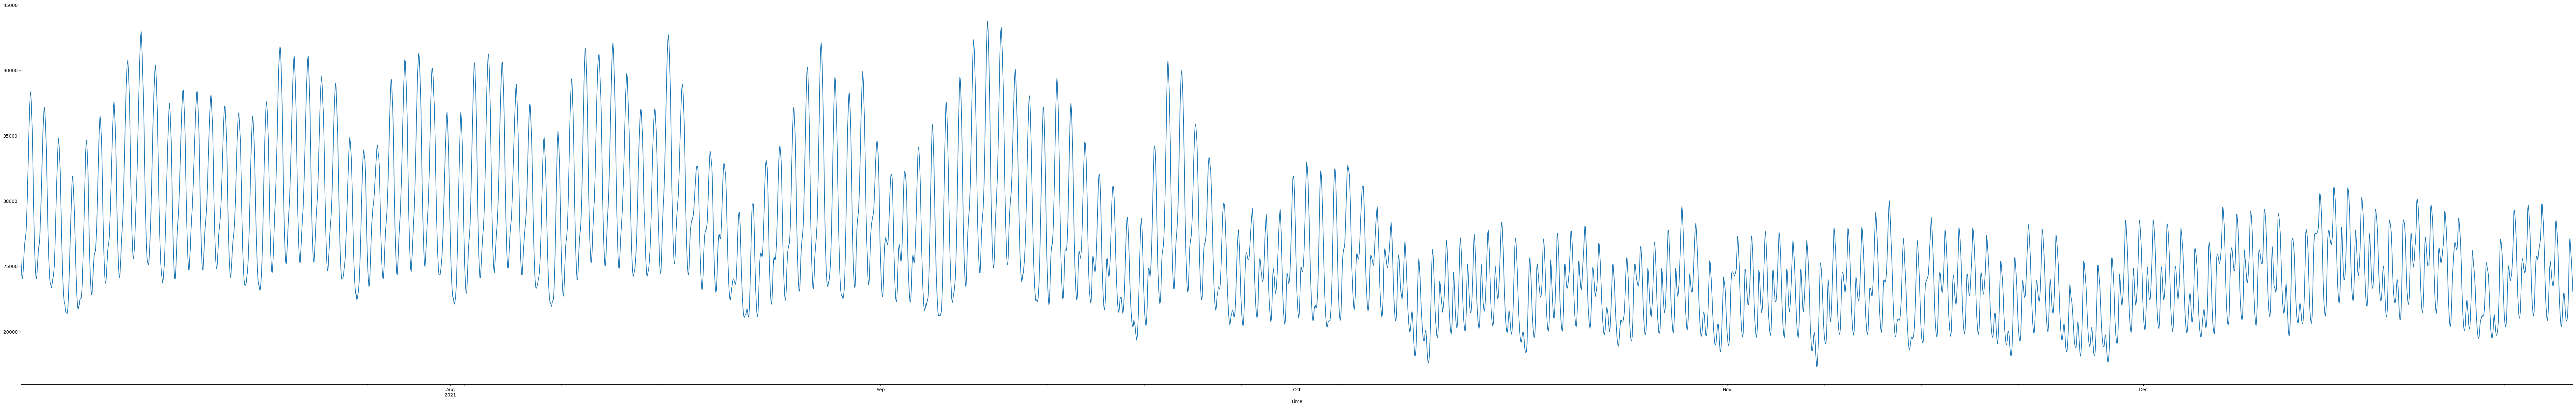

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 100, 15
df['Electric_demand'].plot()

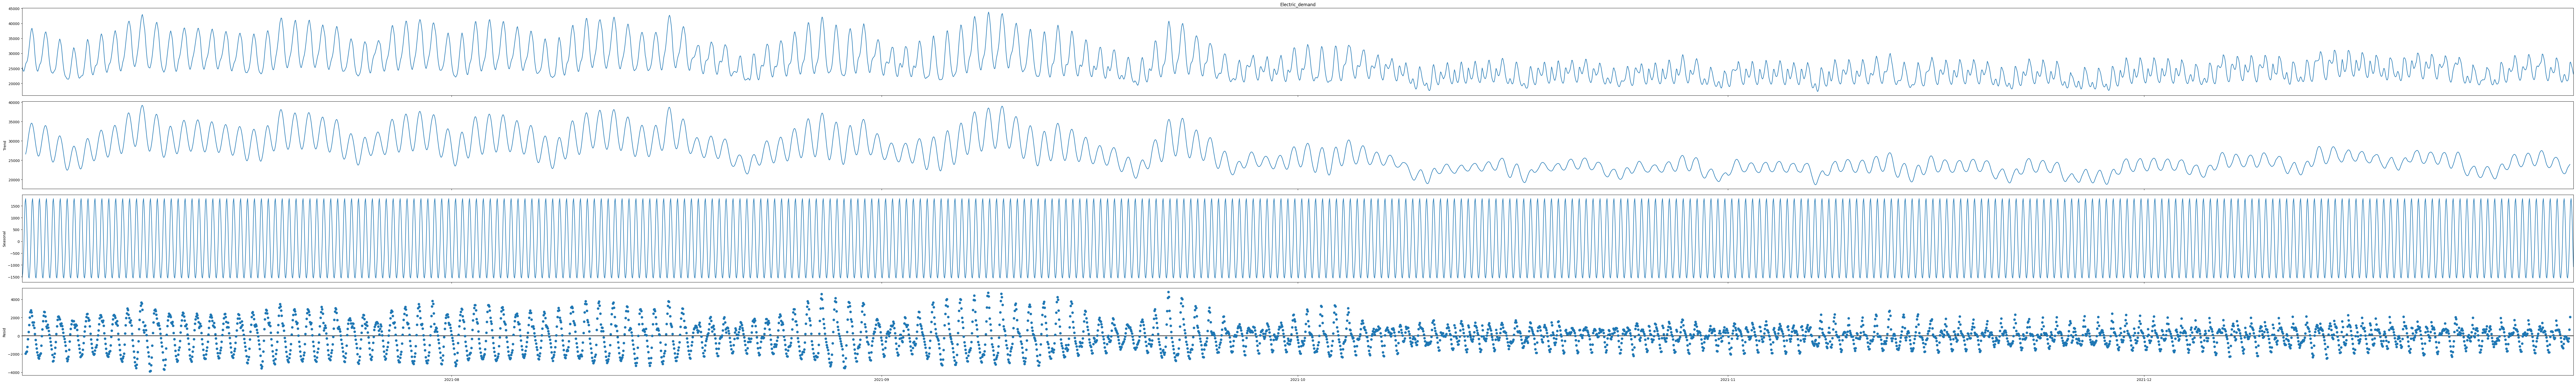

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Electric_demand'], model='additive', period=12) 
result.plot()
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [15]:
adf_test(df['Electric_demand'])

ADF Test Statistic : -3.43970589163894
p-value : 0.00967751488744531
#Lags Used : 31
Number of Observations : 4383
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Figure size 1200x600 with 0 Axes>

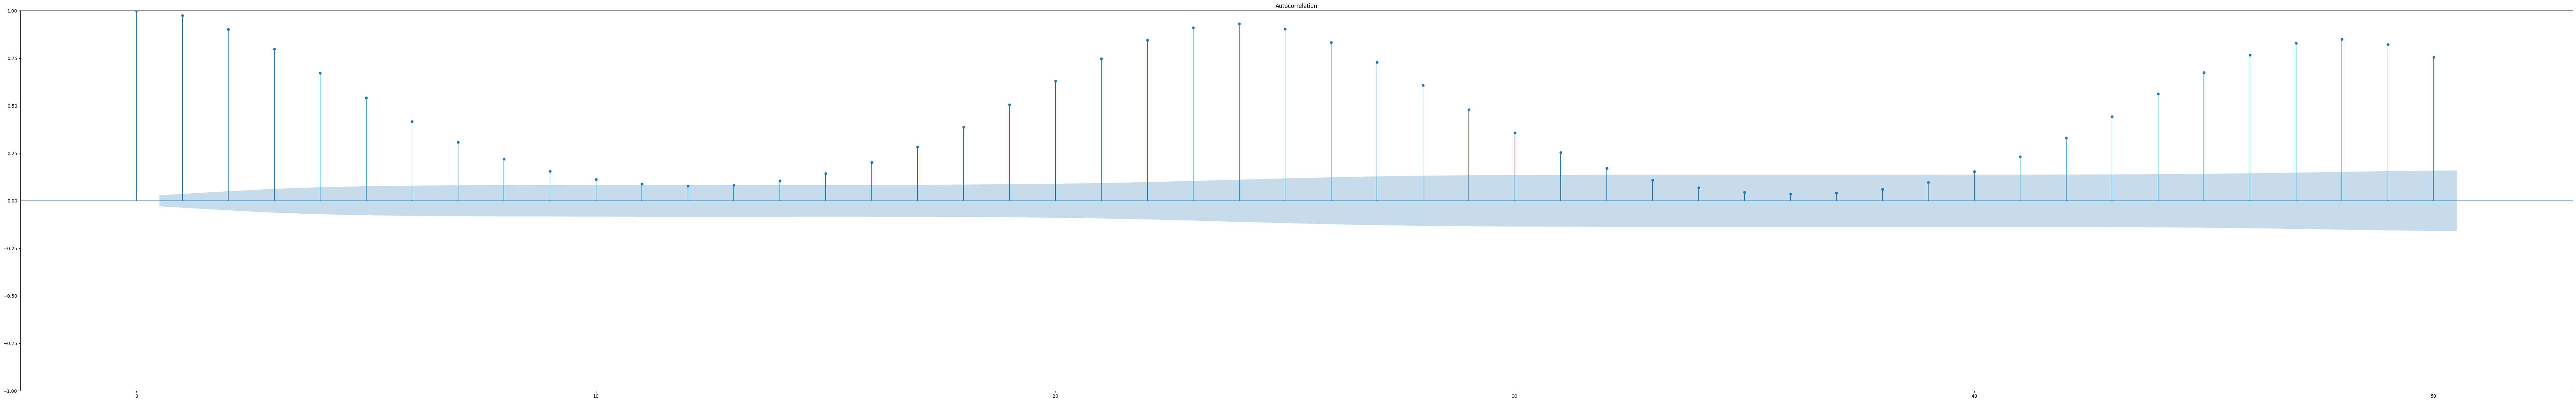

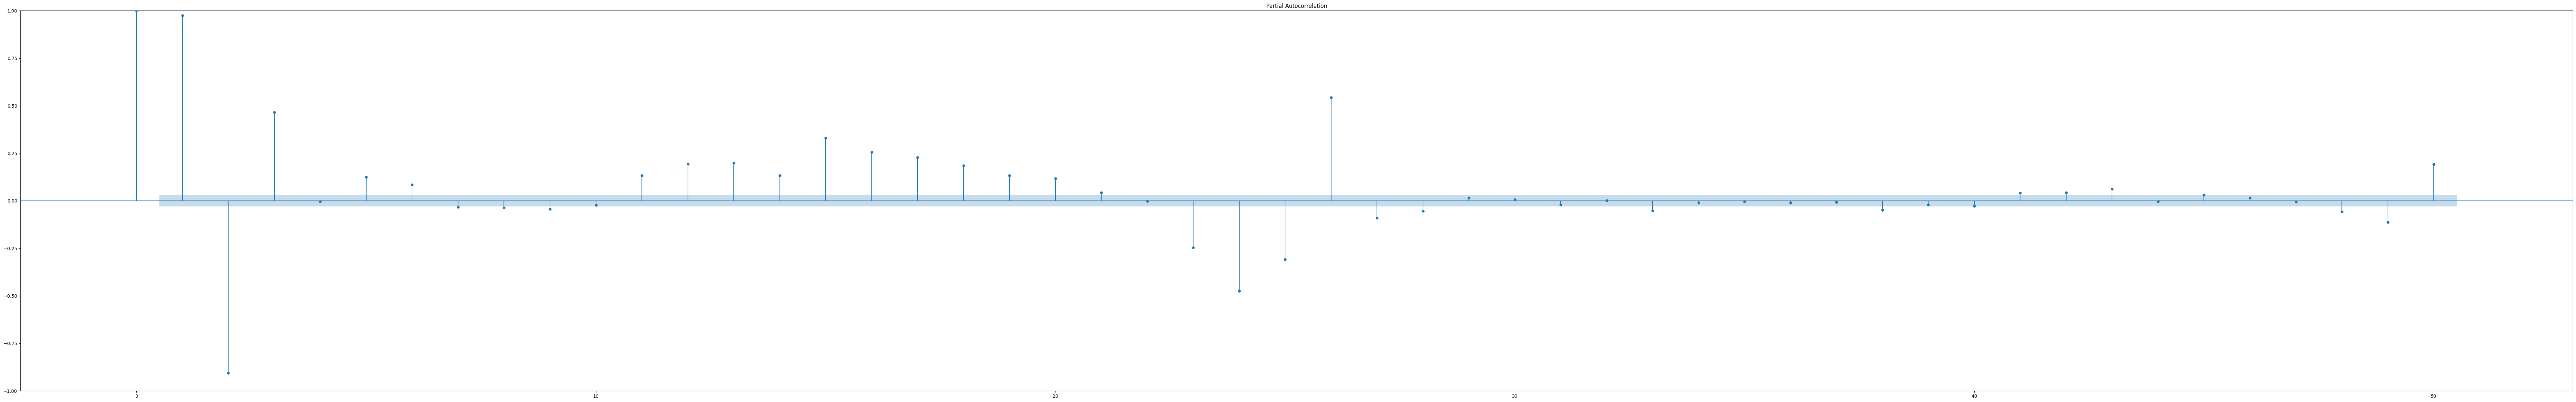

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['Electric_demand'], lags=50) # p = 
plot_pacf(df['Electric_demand'], lags=50) # q = 
plt.show()

# **ARIMA MODEL**

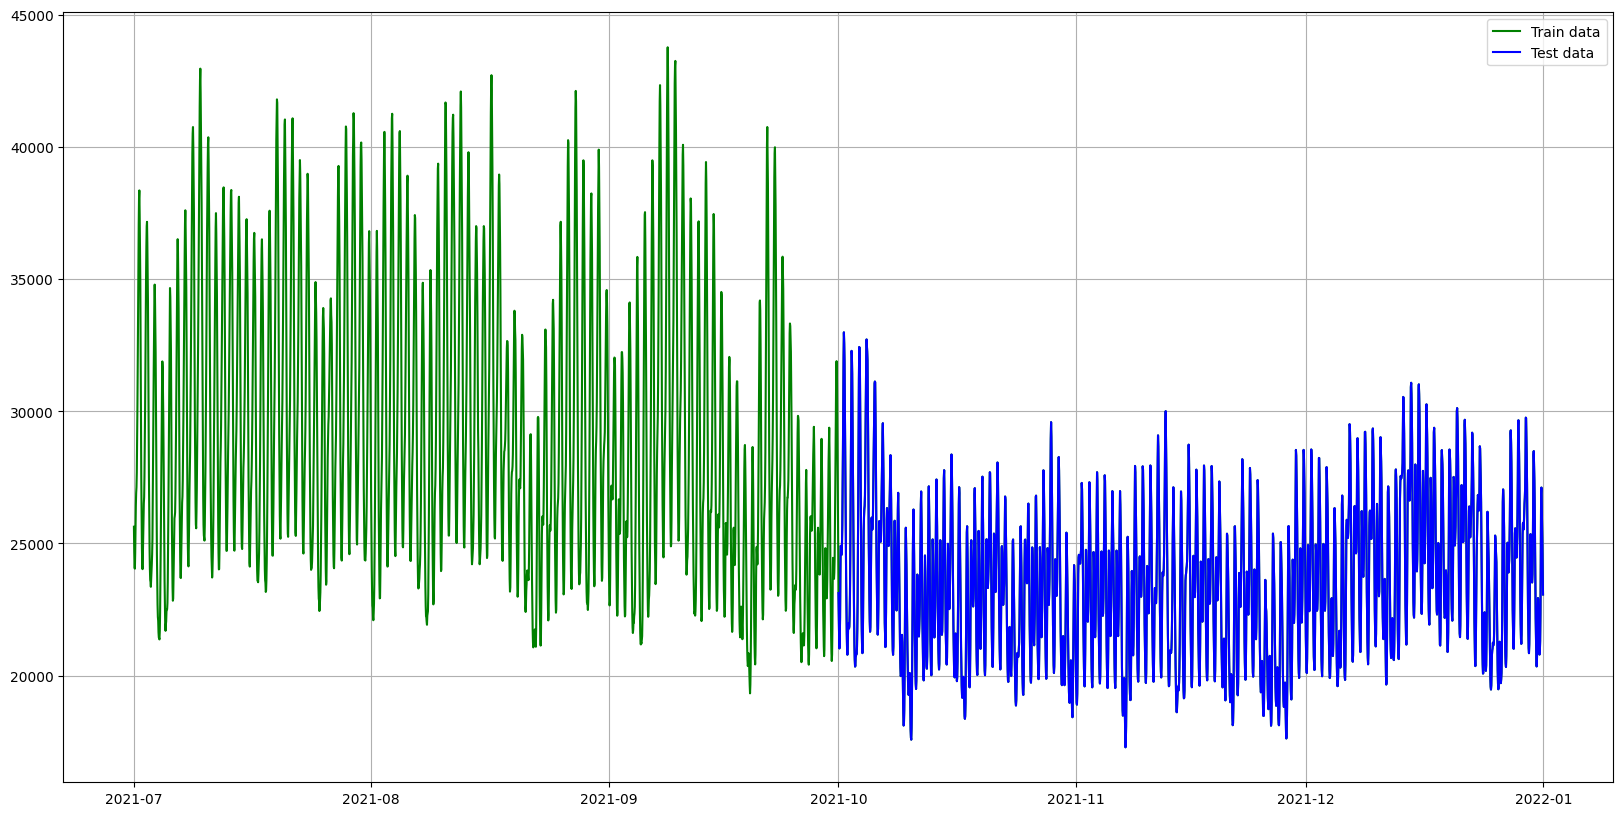

In [17]:
train_data, test_data = df[:int(len(df)*0.5)], df[int(len(df)*0.5):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(df['Electric_demand'], 'green', label='Train data')
plt.plot(test_data['Electric_demand'], 'blue', label='Test data')
plt.legend()

In [18]:
'''import itertools
import warnings
warnings.filterwarnings("ignore")
q_arima = range(0, 12)
d_arima = range(0,1)
p_arima = range(0, 12)
AIC_arima = []
ARIMAX_model = []
pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]

for pdq in pdqs:
    try:
        mod = ARIMA(train_data['Electric_demand'],order=pdq)

        results = mod.fit()
        print('ARIMAX{} - AIC:{}'.format(pdq, results.aic), end='\r')
        AIC_arima.append(results.aic)
        ARIMAX_model.append([(1,1,0), pdq])
    except:
            continue
    
print('The smallest AIC is {} for model ARIMAX{}'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))
order_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'''

'import itertools\nimport warnings\nwarnings.filterwarnings("ignore")\nq_arima = range(0, 12)\nd_arima = range(0,1)\np_arima = range(0, 12)\nAIC_arima = []\nARIMAX_model = []\npdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]\n\nfor pdq in pdqs:\n    try:\n        mod = ARIMA(train_data[\'Electric_demand\'],order=pdq)\n\n        results = mod.fit()\n        print(\'ARIMAX{} - AIC:{}\'.format(pdq, results.aic), end=\'\r\')\n        AIC_arima.append(results.aic)\n        ARIMAX_model.append([(1,1,0), pdq])\n    except:\n            continue\n    \nprint(\'The smallest AIC is {} for model ARIMAX{}\'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))\norder_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'

In [19]:
#The smallest AIC is 31191.33066661339 for model ARIMAX(8, 0, 8)
order_a = (8, 0, 8)

In [20]:
train, test = train_data['Electric_demand'], test_data['Electric_demand']

model = ARIMA(train, order=order_a)
result = model.fit()

forecast_a = result.get_forecast(steps=len(test))
predicted_mean = forecast_a.predicted_mean

mse = mean_squared_error(test, predicted_mean)
rmse = math.sqrt(mse)
print(f'Mean Squared Error: {mse}')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 32478531.228548024


In [21]:
print(mse)
print(rmse)

32478531.228548024
5698.993878619982


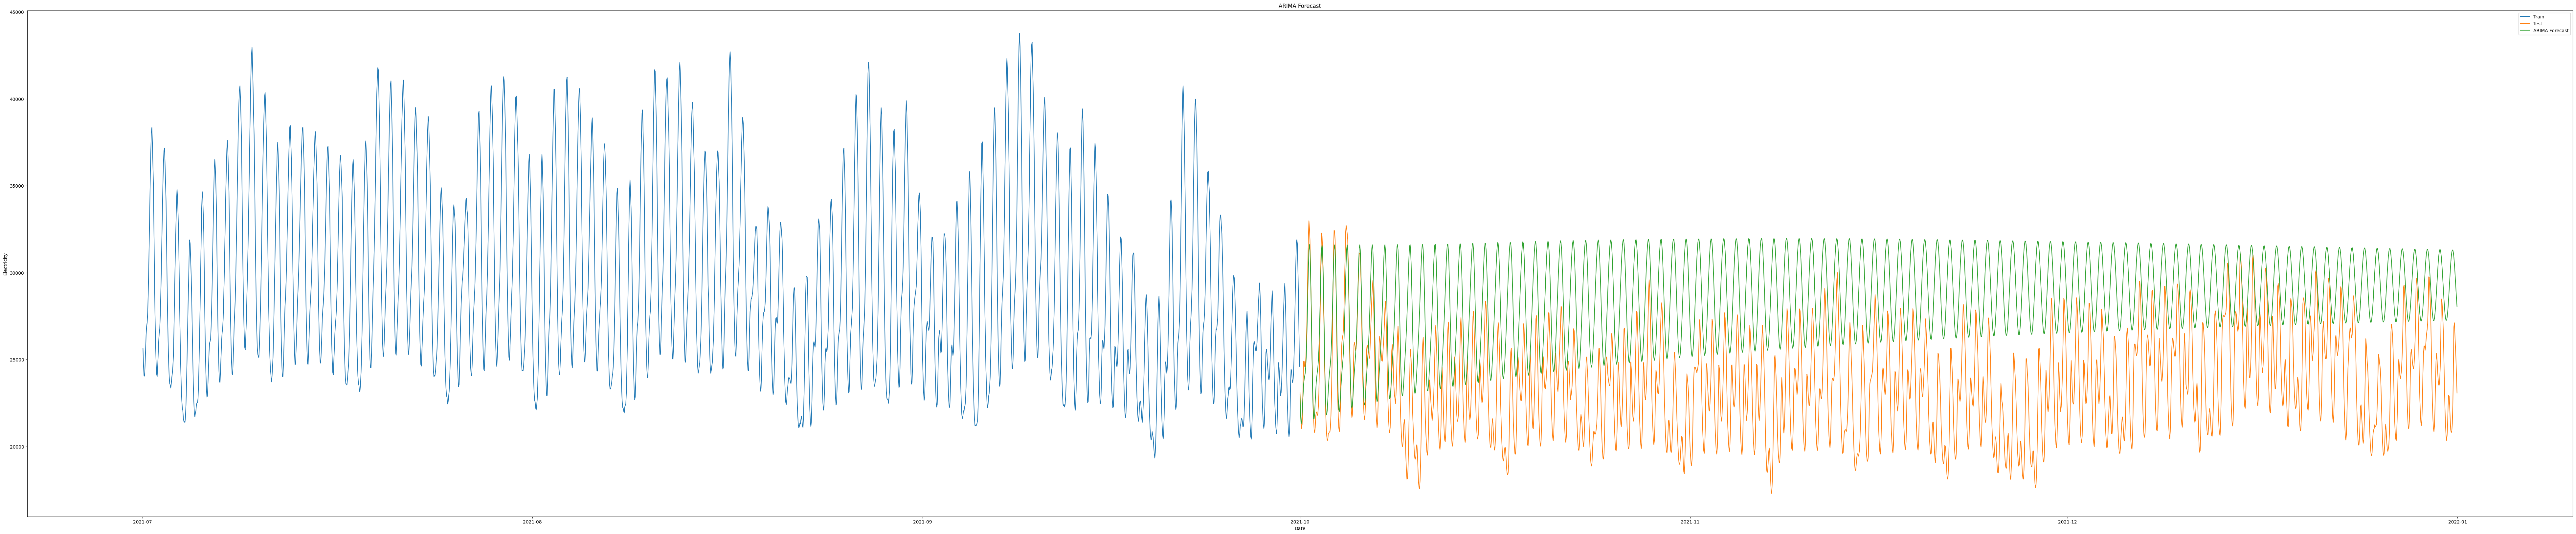

In [22]:
plt.figure(figsize=(100, 20))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predicted_mean, label='ARIMA Forecast')
# plt.fill_between(forecast.conf_int().index,
#                  forecast.conf_int().iloc[:, 0],
#                  forecast.conf_int().iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Electricity')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# **QLSTM MODEL**

In [33]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted','residuals'])
ARIMA_Result['raw'] = test_data['Electric_demand'].copy()
ARIMA_Result['predicted'] = predicted_mean.to_numpy()
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
std_residuals = ARIMA_Result['residuals'].std()
ARIMA_Result['std_residuals'] = ARIMA_Result['residuals'] / std_residuals
ARIMA_Result['nxt_target'] = ARIMA_Result['residuals'].shift(-1)
ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
ARIMA_Result

/tmp/ipykernel_63353/1804258492.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
/tmp/ipykernel_63353/1804258492.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]


raw     predicted    residuals  std_residuals  \
Time                                                                          
2021-10-01 00:00:00  23126.666667  22988.415605   138.251061       0.052189   
2021-10-01 01:00:00  22155.416667  21902.833489   252.583178       0.095350   
2021-10-01 02:00:00  21450.250000  21309.322917   140.927083       0.053200   
2021-10-01 03:00:00  21033.000000  21374.028806  -341.028806      -0.128738   
2021-10-01 04:00:00  21269.000000  21820.588241  -551.588241      -0.208223   
...                           ...           ...          ...            ...   
2021-12-31 19:00:00  26447.333333  30053.546303 -3606.212969      -1.361337   
2021-12-31 20:00:00  25743.083333  29537.034019 -3793.950685      -1.432208   
2021-12-31 21:00:00  25009.250000  29010.336908 -4001.086908      -1.510401   
2021-12-31 22:00:00  24060.250000  28496.126971 -4435.876971      -1.674534   
2021-12-31 23:00:00  23071.916667  28042.738069 -4970.821402      -1.876474   

                      nxt_target  
Time                              
2021-10-01 00:00:00   252.583178  
2021-10-01 01:00:00   140.927083  
2021-10-01 02:00:00  -341.028806  
2021-10-01 03:00:00  -551.588241  
2021-10-01 04:00:00  -271.852297  
...                          ...  
2021-12-31 19:00:00 -3793.950685  
2021-12-31 20:00:00 -4001.086908  
2021-12-31 21:00:00 -4435.876971  
2021-12-31 22:00:00 -4970.821402  
2021-12-31 23:00:00 -4970.821402  

[2208 rows x 5 columns]

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time

In [35]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:]) 
    data = scaler2.fit_transform(data.iloc[:,:1])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [36]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 2
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 1
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [37]:
size = int(len(ARIMA_Result) * 0.5)

train = ARIMA_Result[['residuals','nxt_target']][:size].copy()
test = ARIMA_Result[['residuals','nxt_target']][size:].copy()

In [38]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [39]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [40]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [41]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionLSTM(num_sensors=1, hidden_units= 6, n_qubits=1)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 1)


In [42]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}')

[1/5]  LossQ:229.80632549664006
[2/5]  LossQ:232.3165127002867
[3/5]  LossQ:171.30115240684245
[4/5]  LossQ:111.96154276863672
[5/5]  LossQ:90.80023453454487


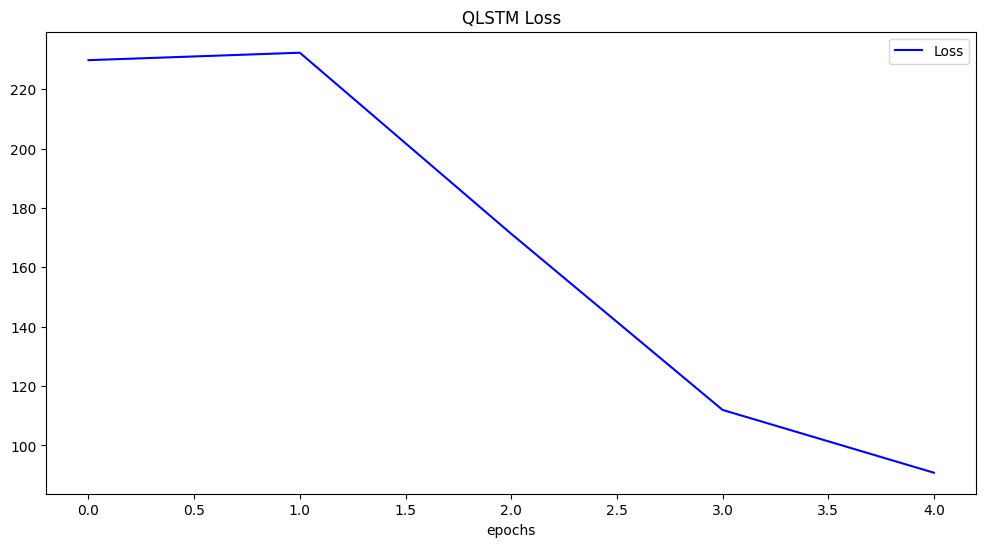

In [43]:
np.savetxt('./SavedModels/Electricity/RE_elecDemand/loss/arima_qlstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [44]:
histQ1 = histQ 

In [45]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [46]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([ 1.3962,  1.3952,  1.4087,  ..., -0.0062, -0.1596, -0.3177],
       grad_fn=<ViewBackward0>)


In [47]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
pred_y_train

tensor([[ 1.3962],
        [ 1.3952],
        [ 1.4087],
        ...,
        [-0.0062],
        [-0.1596],
        [-0.3177]], grad_fn=<ViewBackward0>)

In [48]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [49]:
np.savetxt('./SavedModels/Electricity/RE_elecDemand/train/arima_qlstm.txt',y_train_pred)
np.savetxt('./SavedModels/Electricity/RE_elecDemand/test/arima_qlstm.txt',y_test_pred)

Training dataset MSE: 2415635.6524121086 RMSE:1554.2315311471802


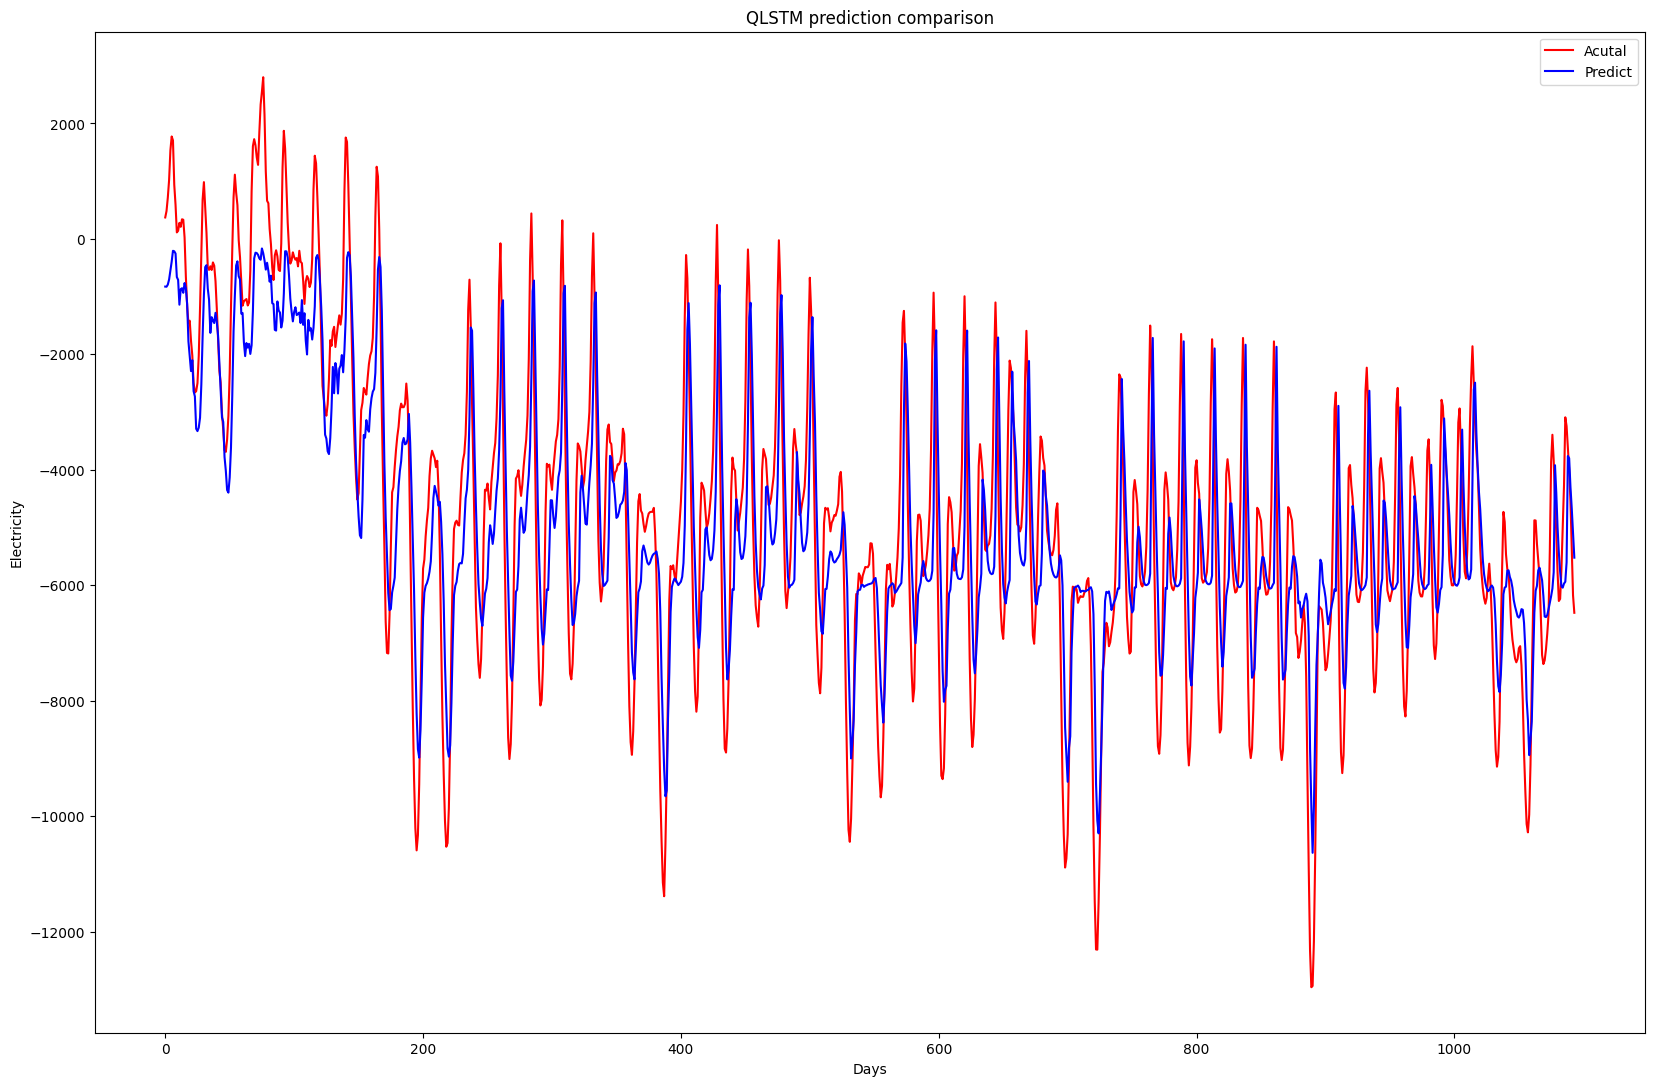

In [50]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset MSE:2909547.55136152 RMSE:1705.7395907234843


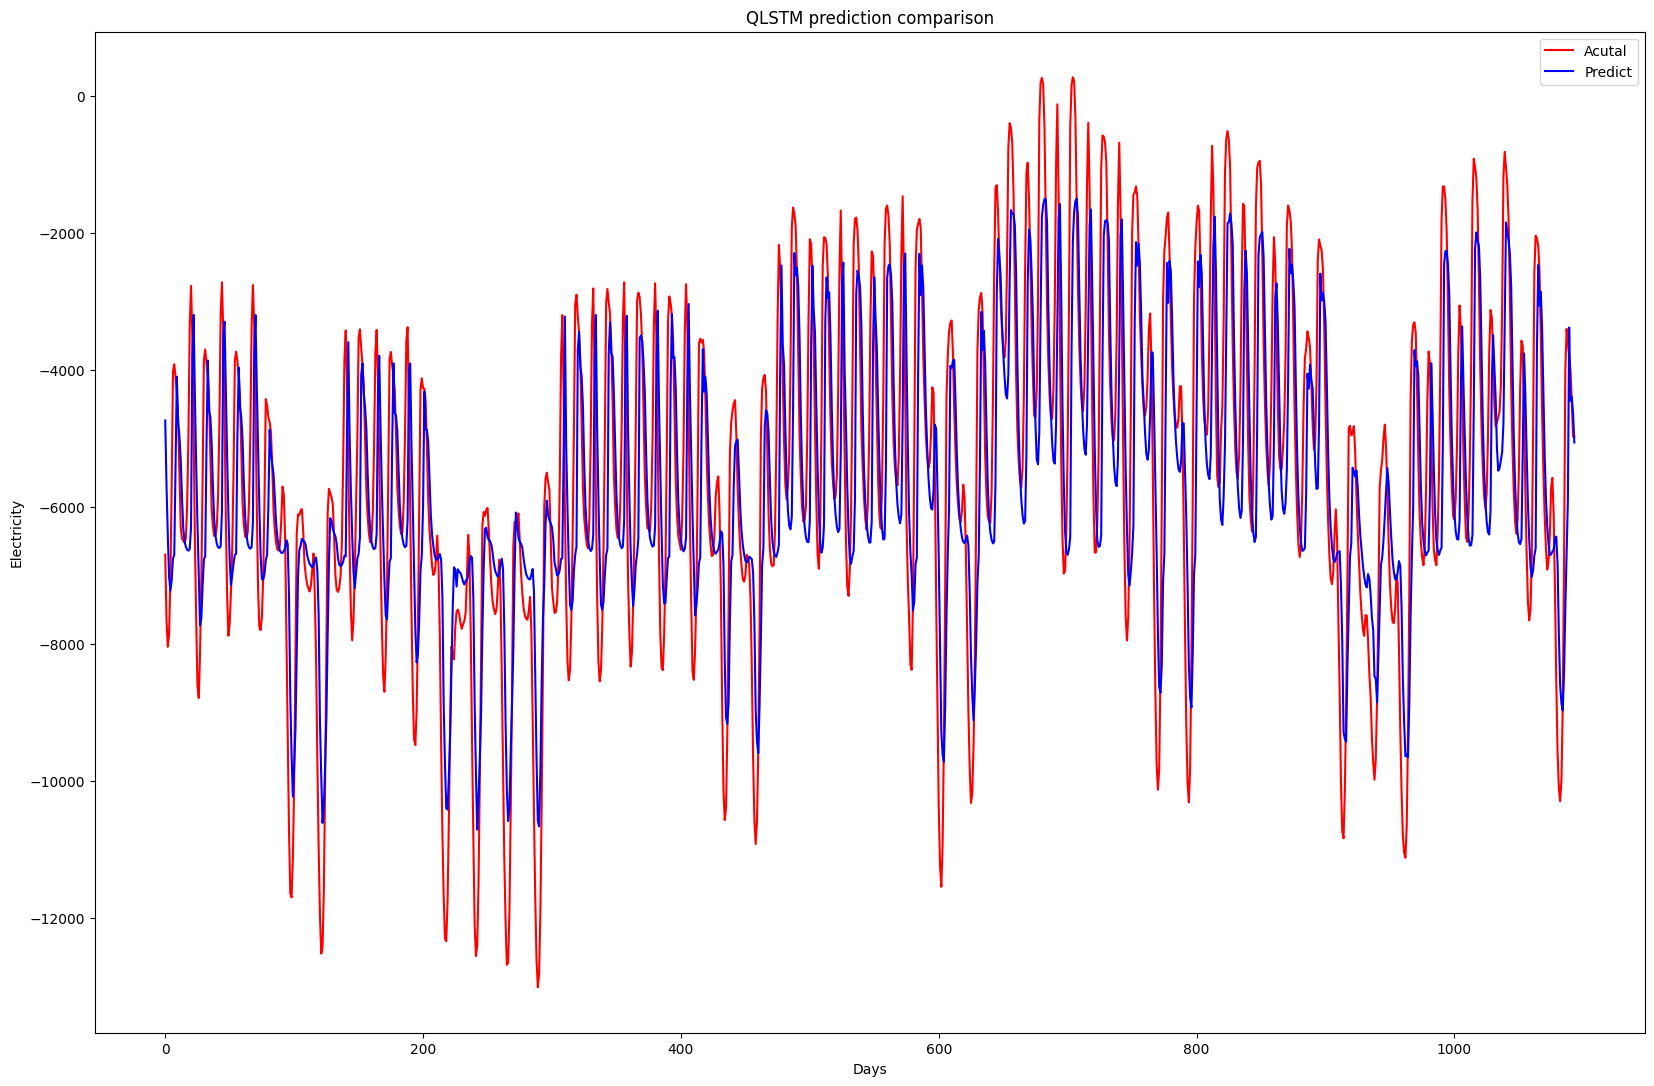

In [51]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE:{MSE} RMSE:{RMSE}')

In [52]:
final_result_qlstm = ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [53]:
frq = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
frq['final'] = final_result_qlstm
frq

predicted           raw         final
Time                                                         
2021-11-16 10:00:00  29186.326343  23793.916667  24451.394703
2021-11-16 11:00:00  29947.240311  23255.500000  24256.890213
2021-11-16 12:00:00  30622.284526  22970.583333  24202.439800
2021-11-16 13:00:00  31206.064906  23168.000000  24185.057581
2021-11-16 14:00:00  31623.847345  23771.083333  24405.425958
...                           ...           ...           ...
2021-12-31 19:00:00  30053.546303  26447.333333  26675.413002
2021-12-31 20:00:00  29537.034019  25743.083333  25088.603355
2021-12-31 21:00:00  29010.336908  25009.250000  24617.845208
2021-12-31 22:00:00  28496.126971  24060.250000  23877.683124
2021-12-31 23:00:00  28042.738069  23071.916667  22986.185823

[1094 rows x 3 columns]

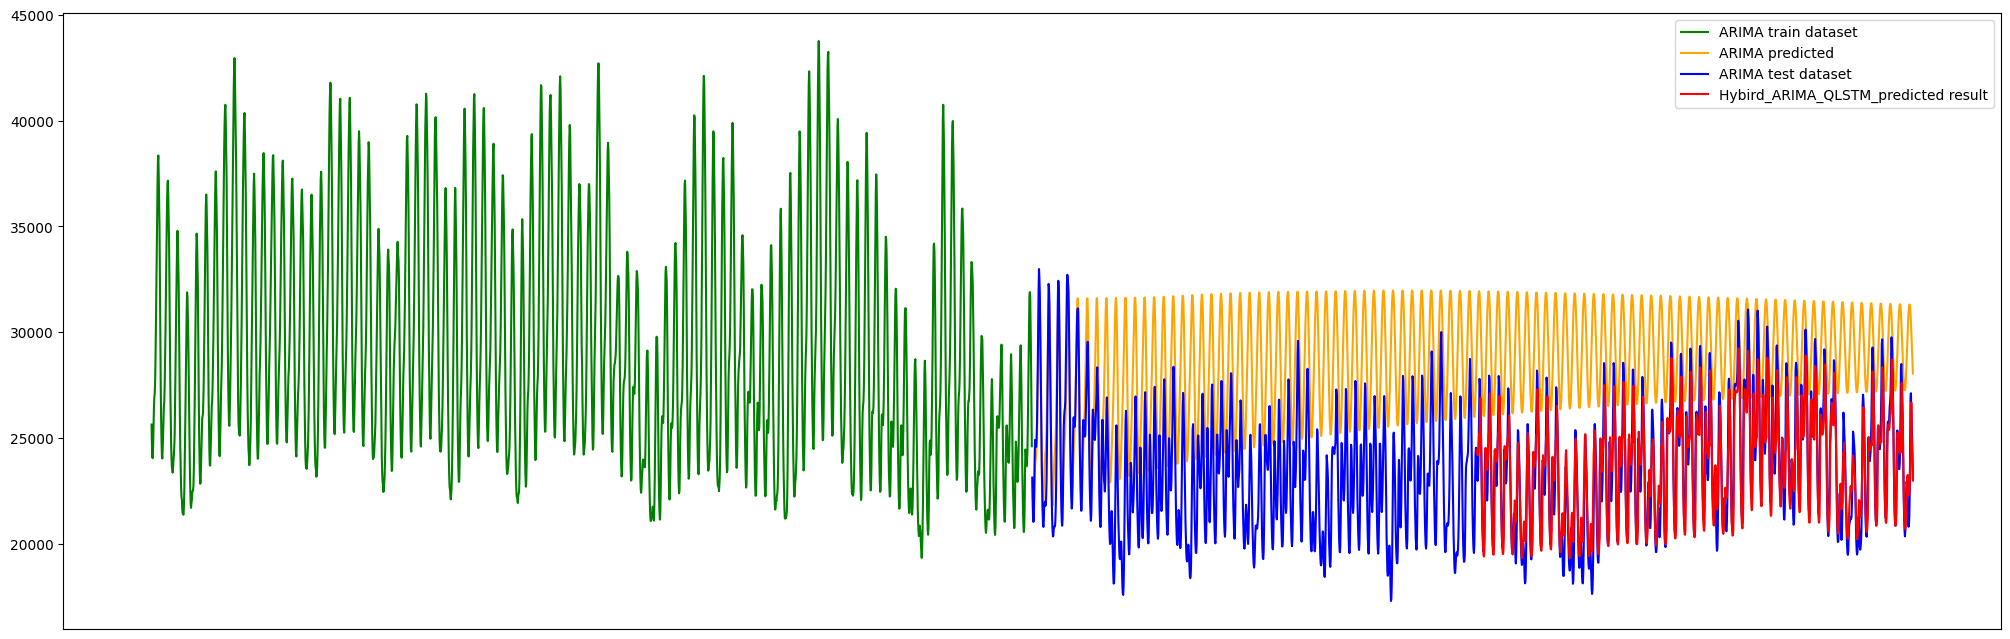

In [54]:
plt.figure(figsize=(25,8))
plt.plot(train_data['Electric_demand'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result', color='red')
#plt.axvline(x=len(train_data['Global_active_power']), c='black', linestyle='--')
#plt.axvline(x=len(train_data['Global_active_power']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result_qlstm,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result_qlstm, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 1357737.0877835278
X_test MAE: 851.6407807101846
X_test RMSE: 1165.2197594374752


In [56]:
torch.save(modelQ.state_dict(),'./SavedModels/Electricity/RE_elecDemand/model/arima_QLSTM_sd')

# **LSTM MODEL**

In [57]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [58]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=1, hidden_units=6)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [59]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:205.93462163722143 


[2/5]  LossQ:93.23325370962266 
[3/5]  LossQ:54.9403266669251 
[4/5]  LossQ:41.43308689806145 
[5/5]  LossQ:39.44329946860671 


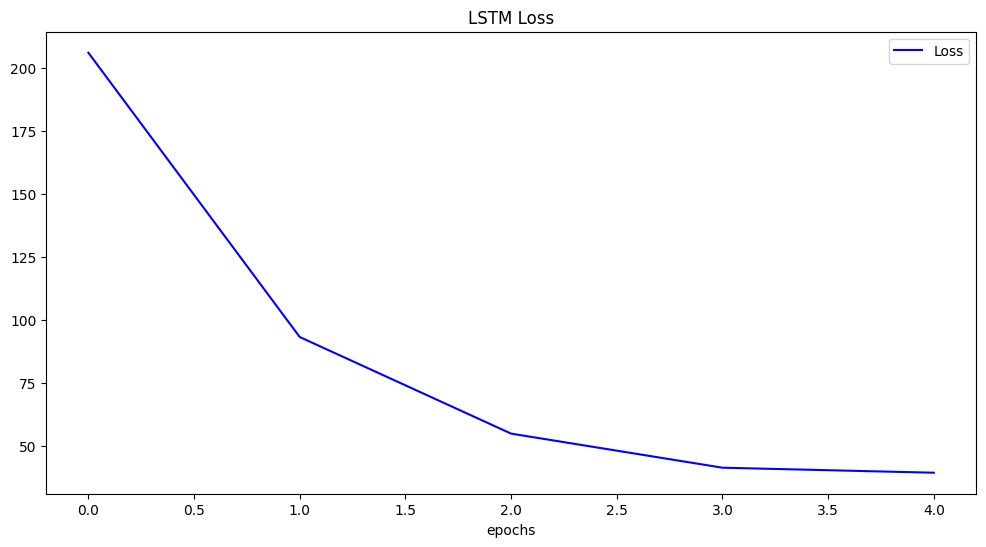

In [60]:
np.savetxt('./SavedModels/Electricity/RE_elecDemand/loss/arima_lstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [61]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)

In [62]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [63]:
np.savetxt('./SavedModels/Electricity/RE_elecDemand/train/arima_lstm.txt',y_train_pred)
np.savetxt('./SavedModels/Electricity/RE_elecDemand/test/arima_lstm.txt',y_test_pred)

Training dataset MSE: 2037185.8979794264 RMSE:1427.3002129823376


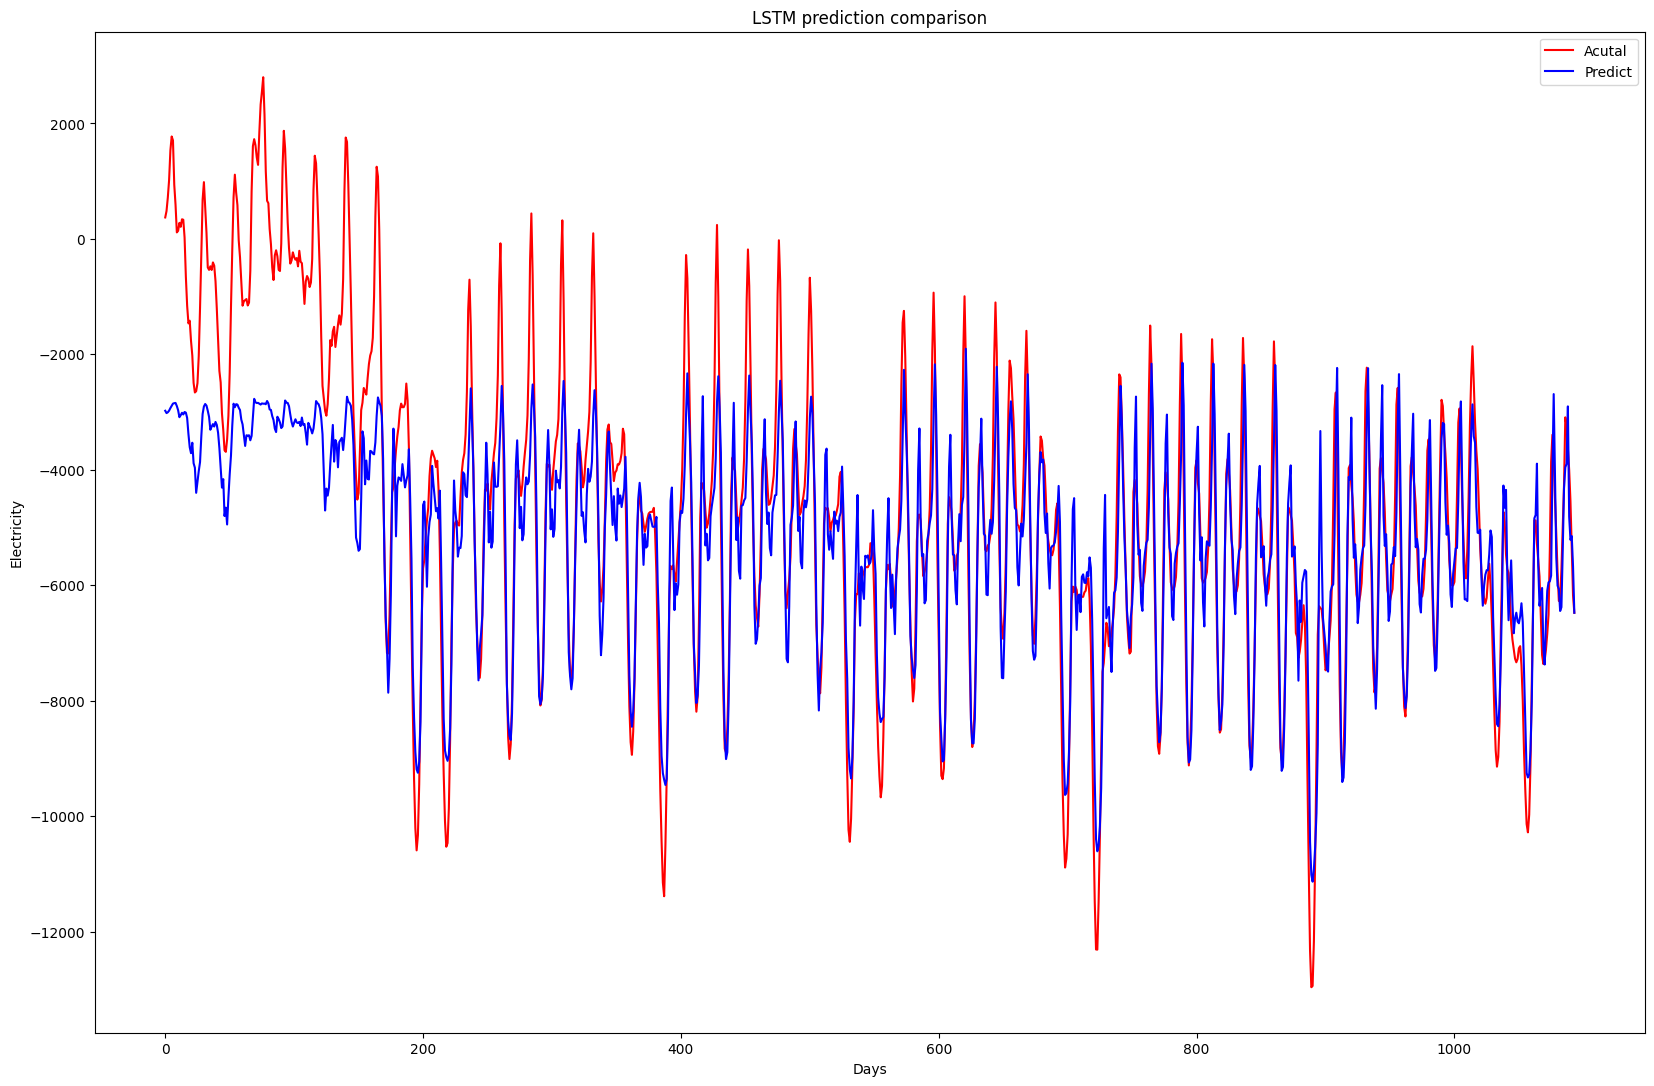

In [64]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset RMSE:1232.593915602321


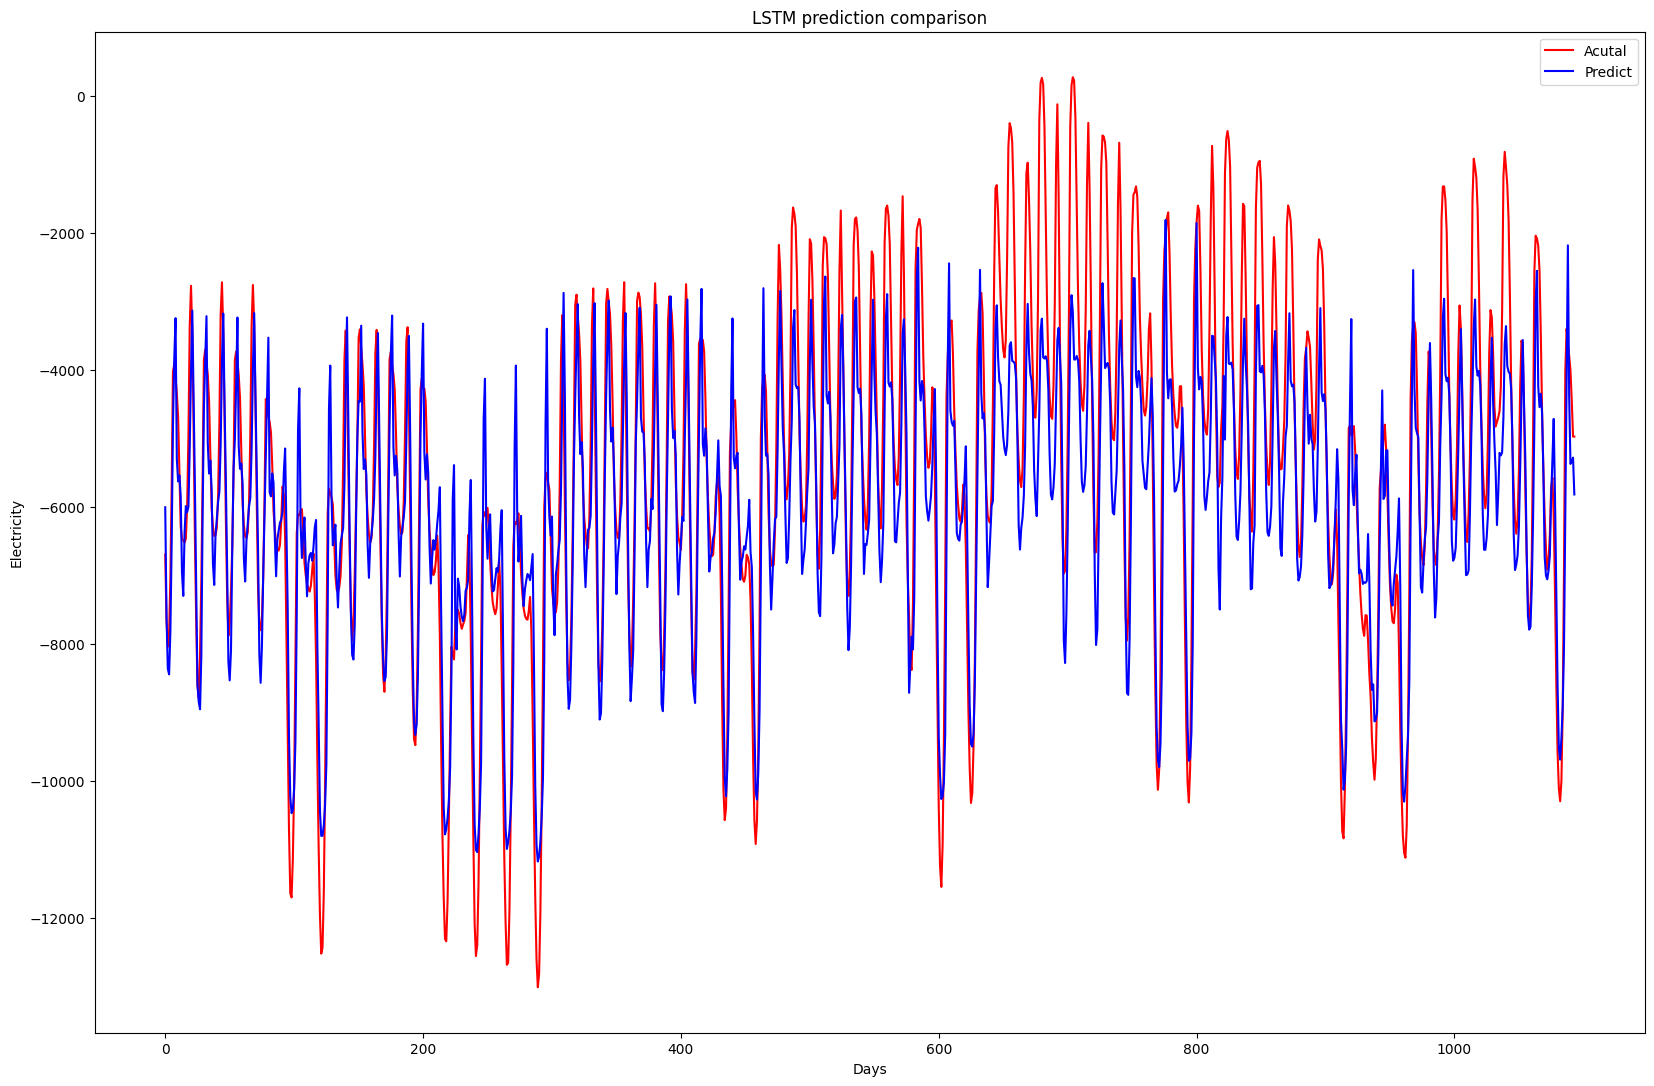

In [65]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('Electricity')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [66]:
final_result= ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [67]:
fr = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
fr['final'] = final_result
fr

predicted           raw         final
Time                                                         
2021-11-16 10:00:00  29186.326343  23793.916667  23184.650074
2021-11-16 11:00:00  29947.240311  23255.500000  22354.299881
2021-11-16 12:00:00  30622.284526  22970.583333  22265.683940
2021-11-16 13:00:00  31206.064906  23168.000000  22766.334437
2021-11-16 14:00:00  31623.847345  23771.083333  23810.209162
...                           ...           ...           ...
2021-12-31 19:00:00  30053.546303  26447.333333  25667.649330
2021-12-31 20:00:00  29537.034019  25743.083333  24167.879234
2021-12-31 21:00:00  29010.336908  25009.250000  23673.942865
2021-12-31 22:00:00  28496.126971  24060.250000  23218.925311
2021-12-31 23:00:00  28042.738069  23071.916667  22227.804963

[1094 rows x 3 columns]

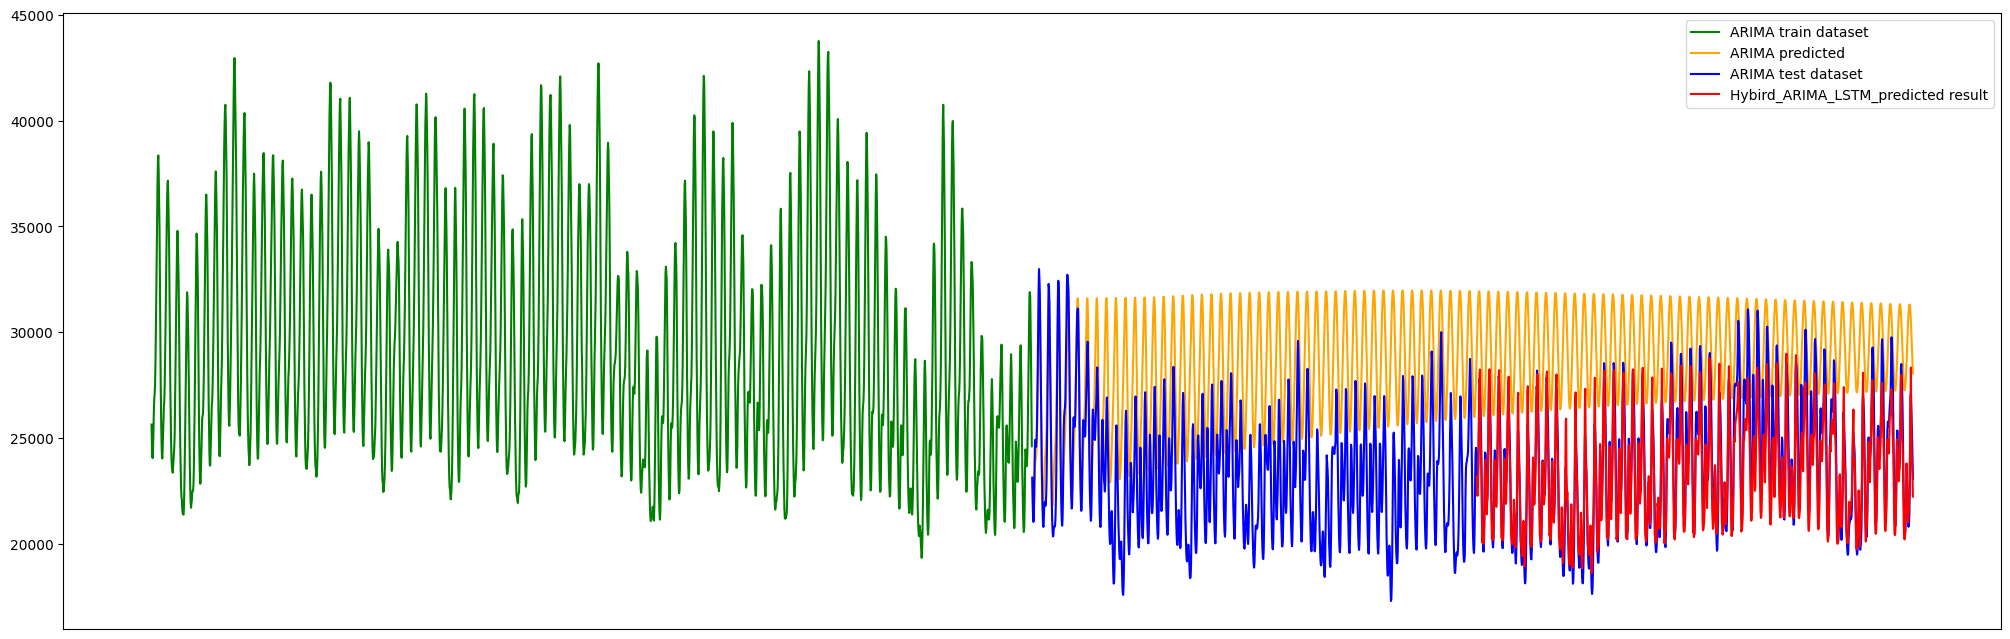

In [68]:
plt.figure(figsize=(25,8))
plt.plot(train_data['Electric_demand'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result', color='red')
#plt.axvline(x=len(train_data['Global_active_power']), c='black', linestyle='--')
#plt.axvline(x=len(train_data['Global_active_power']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

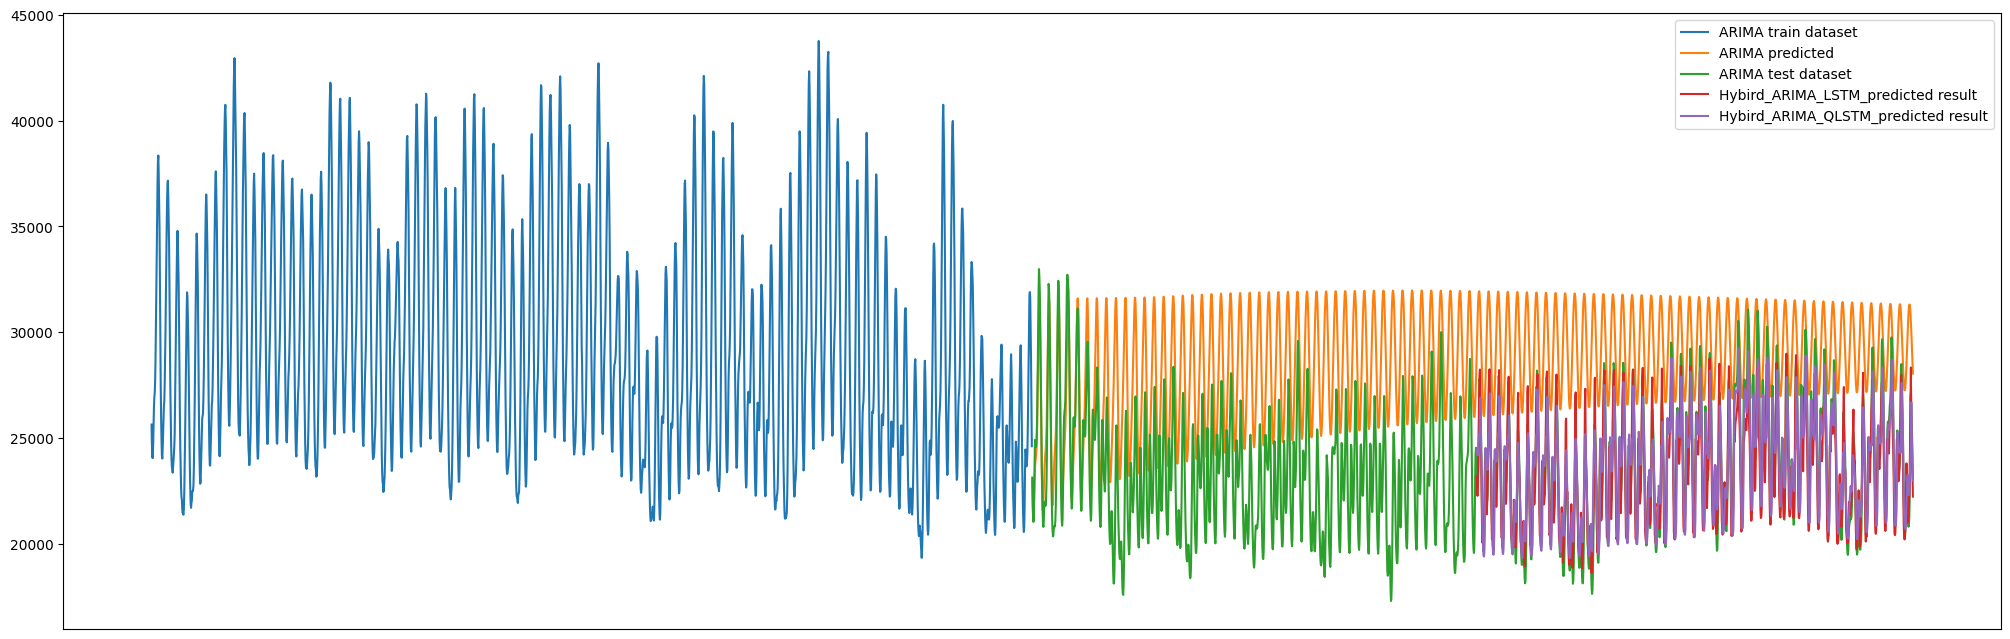

In [69]:
plt.figure(figsize=(25,8))
plt.plot(train_data['Electric_demand'], label ='ARIMA train dataset')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset")
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result')
#plt.axvline(x=len(train_data['Global_active_power']), c='black', linestyle='--')
#plt.axvline(x=len(train_data['Global_active_power']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 1306901.5385170584
X_test MAE: 890.0804281433907
X_test RMSE: 1143.1979437162483


In [71]:
torch.save(modelQ,'./SavedModels/Electricity/RE_elecDemand/model/arima_lstm')

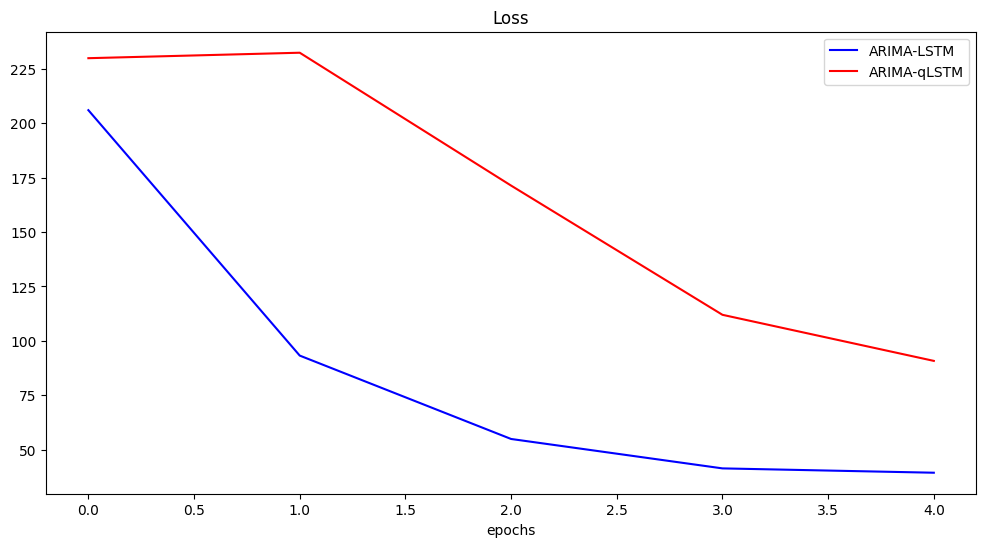

In [72]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'ARIMA-LSTM')
plt.plot(histQ1, color='red', label='ARIMA-qLSTM')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')